In [1]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.edgecolor"] = "none"

import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
mplhep.style.use(["CMS", "firamath"])


In [2]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [44]:
hpt_axis = hist.axis.Regular(
    40, 0, 800, name="hpt", label=r"Gen Higgs p$_T$"
)
sample_axis = hist.axis.StrCategory([], name="name", growth=True)
tag_axis = hist.axis.StrCategory([], name="tag", growth=True)
h_hpt = hist.Hist(hpt_axis, sample_axis, tag_axis)
h_hpt_noweight = hist.Hist(hpt_axis, sample_axis, tag_axis)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan5_nosel_2016/"
ch = "mu"
tag = "all"
samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "VBF lnuqq": ["VBFHToWWToLNuQQ_M-125_withDipoleRecoil"],
    "VBF": ["VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil"],
    "VH": [
        "HWminusJ_HToWW_M-125",
        "HZJ_HToWW_M-125",
        "HWplusJ_HToWW_M-125",
    ],
    "ttH WW": ["ttHToNonbb_M125"],
}
year = "2016"

for key,samples in samples_dict.items():
    for sample in samples:
        parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

        data = pd.read_parquet(parquet_files, columns=["fj_genH_pt", f"weight_{ch}"])

        luminosity = 137640.0

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"]

        hpt = data["fj_genH_pt"].values
        h_hpt.fill(hpt, key, tag, weight=event_weight)
        h_hpt_noweight.fill(hpt, key, tag)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan5_sel_signal_2016/"
ch = "mu"
tag = "ww"
samples_dict = {
    "ttH WW": ["ttHToNonbb_M125"],
}
year = "2016"

for key,samples in samples_dict.items():    
    for sample in samples:
        parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

        data = pd.read_parquet(parquet_files, columns=["fj_genH_pt", f"weight_{ch}"])

        luminosity = 137640.0

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"] #* 0.508

        # BR_HBB = 0.580
        # BR_HWW = 0.2137
        # 1-BR_HBB = 0.42
        # BR_HWW / (1-BR_HBB)= 0.508

        hpt = data["fj_genH_pt"].values
        h_hpt.fill(hpt, key, tag, weight=event_weight)
        h_hpt_noweight.fill(hpt, key, tag)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan15_sel_signal_2016/"
ch = "mu"
tag = "ww_sel"
samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "ttH WW": ["ttHToNonbb_M125"],
}
year = "2016"

for key,samples in samples_dict.items():    
    for sample in samples:
        parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

        data = pd.read_parquet(parquet_files, columns=["fj_genH_pt", f"weight_{ch}"])

        luminosity = 137640.0

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"] 
        if sample=="ttHToNonbb_M125":
            event_weight *= 0.508

        hpt = data["fj_genH_pt"].values
        h_hpt.fill(hpt, key, tag, weight=event_weight)
        h_hpt_noweight.fill(hpt, key, tag)


In [46]:
h_ggh = h_hpt[{"name": "ggH", "tag": "all"}]
h_vh = h_hpt[{"name": "VH", "tag": "all"}]
h_vbf = h_hpt[{"name": "VBF", "tag": "all"}]
h_tth = h_hpt[{"name": "ttH WW", "tag": "ww"}]
h_sum = h_ggh + h_vbf + h_vh + h_tth

In [24]:
# compare stats of vbf samples
h_vbf = h_hpt_noweight[{"name": "VBF", "tag": "all"}]
h_vbf_lnuqq = h_hpt_noweight[{"name": "VBF lnuqq", "tag": "all"}]

print("VBF ", h_vbf.sum())
print("VBF x lnuqq BR ", h_vbf.sum() * 0.433)
print("VBF lnuqq ", h_vbf_lnuqq.sum())


VBF  1436478.0
VBF x lnuqq BR  621994.974
VBF lnuqq  124989.0


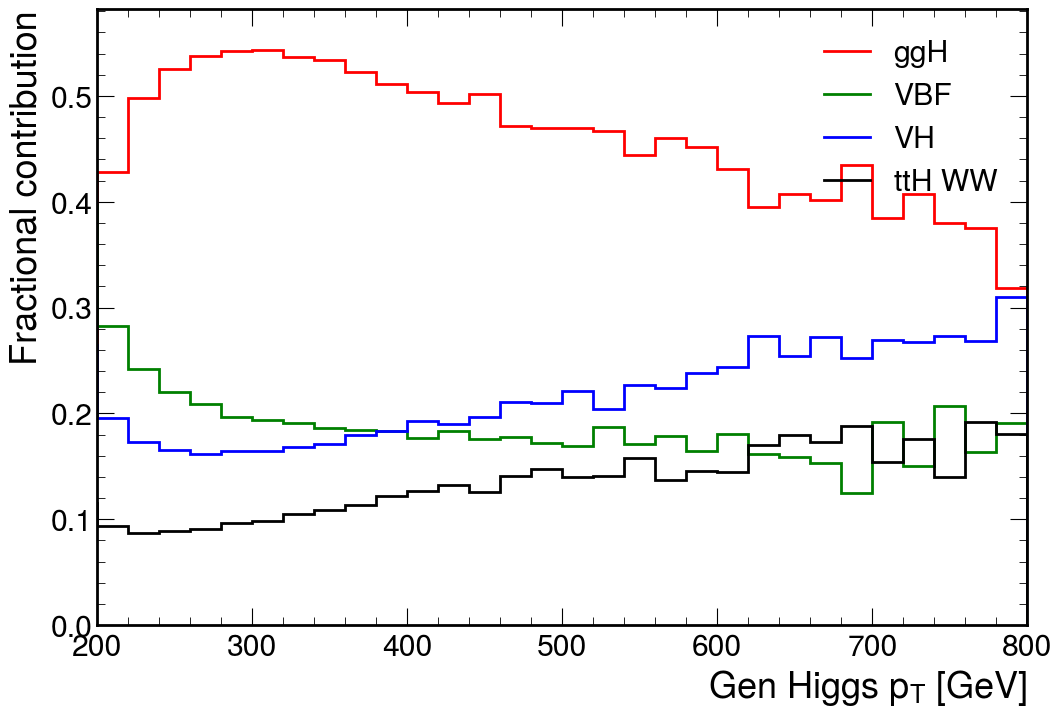

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    # "VBF lnuqq": "teal",
    "VH": "blue",
    "ttH WW": "black",
}
for key in color_by_sample.keys():
    if "ttH" in key:
        h = h_hpt[{"name": key, "tag": "ww"}]
    else:
        h = h_hpt[{"name": key, "tag": "all"}]

    mplhep.histplot(
        h/h_sum,
        #density=True,
        lw=2,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.legend(handles=legend_elements)
# this is not quite true since the ggH sample only starts at 200..
ax.set_ylabel("Fractional contribution")
ax.set_xlim(200, 800)
ax.set_xlabel(r"Gen Higgs p$_T$ [GeV]")
fig.savefig("hpt_fractional.png")

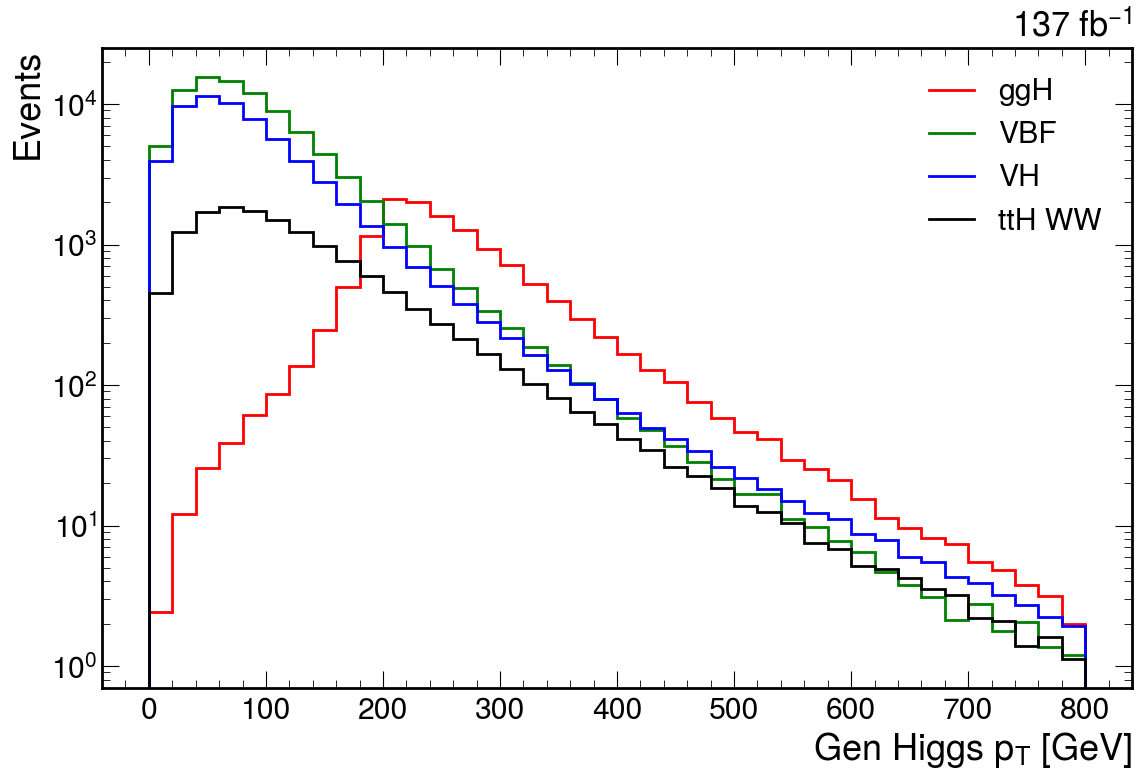

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    #"VBF lnuqq": "teal",
    "VH": "blue",
    "ttH WW": "black",
}
for key in color_by_sample.keys():
    if "ttH" in key:
        h = h_hpt[{"name": key, "tag": "ww"}]
    else:
        h = h_hpt[{"name": key, "tag": "all"}]

    mplhep.histplot(
        h,
        #density=True,
        lw=2,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Events")
ax.set_xlabel(r"Gen Higgs p$_T$ [GeV]")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("hpt_all.png")

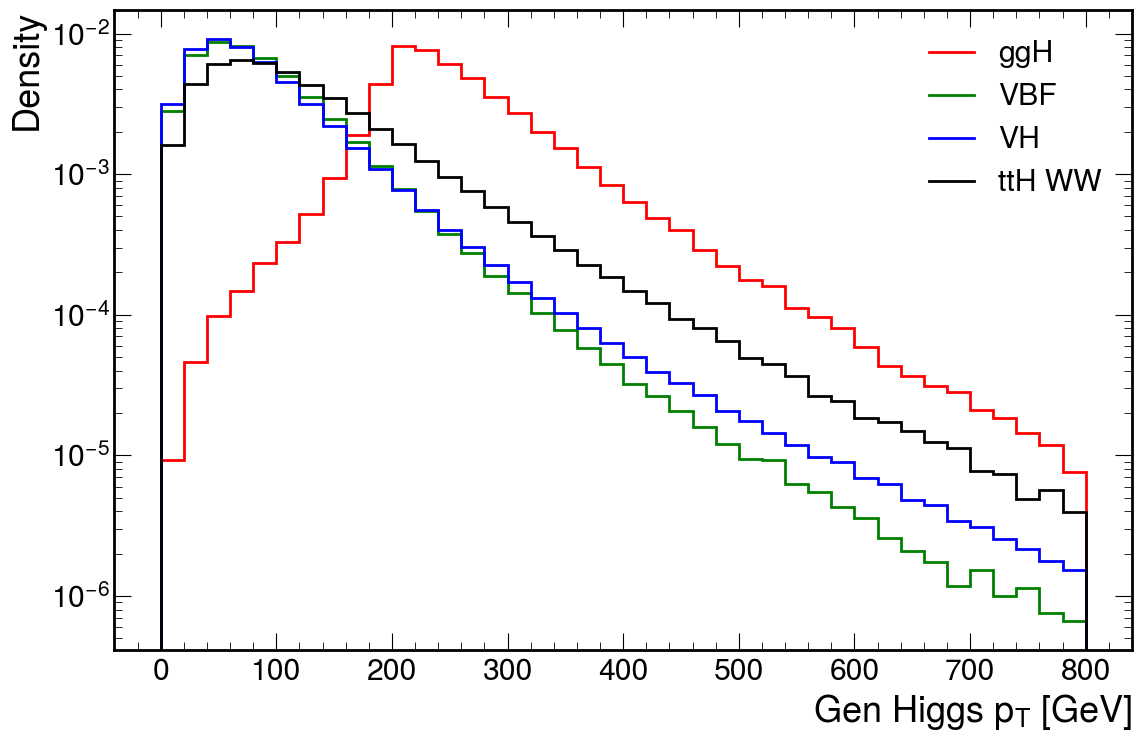

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    #"VBF lnuqq": "teal",
    "VH": "blue",
    "ttH WW": "black",
}
for key in color_by_sample.keys():
    if "ttH" in key:
        h = h_hpt[{"name": key, "tag": "ww"}]
    else:
        h = h_hpt[{"name": key, "tag": "all"}]

    mplhep.histplot(
        h,
        density=True,
        lw=2,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Density")
ax.set_xlabel(r"Gen Higgs p$_T$ [GeV]")
plt.tight_layout()
fig.savefig("hpt_all_density.png")

27729.66538929791
14148.967622598238
14096.371489274115


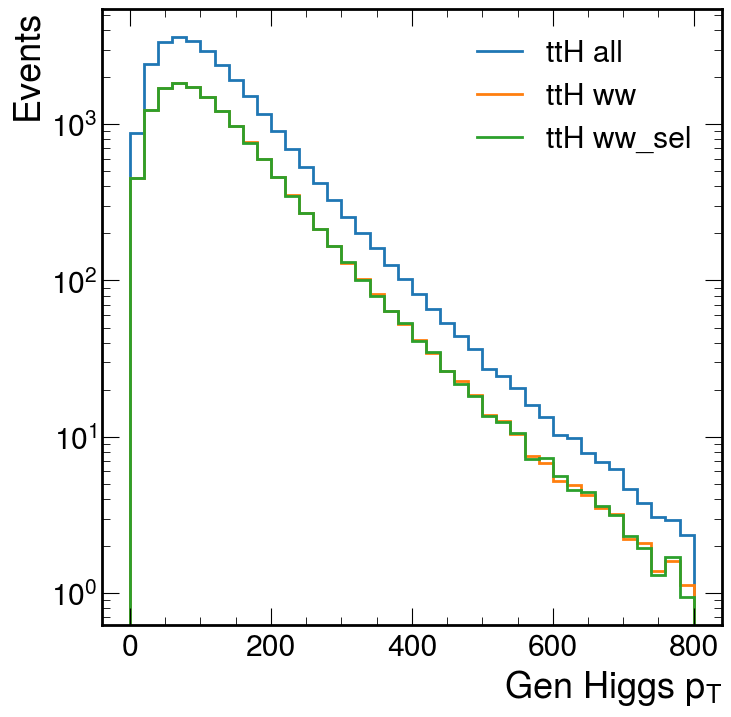

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["ttH WW"]:
    for tag in ["all", "ww", "ww_sel"]:
        mplhep.histplot(
            h_hpt[{"name": key, "tag": tag}],
            #density=True,
            lw=2,
            label=f"ttH {tag}",
            flow="none"
        )
        print(h_hpt[{"name": key, "tag": tag}].sum())
ax.set_yscale("log")
ax.set_ylabel("Events")        
ax.legend()
# 14148.967622598238 / 27729.66538929791 = 0.51

13102.099630918496
13102.099630918496


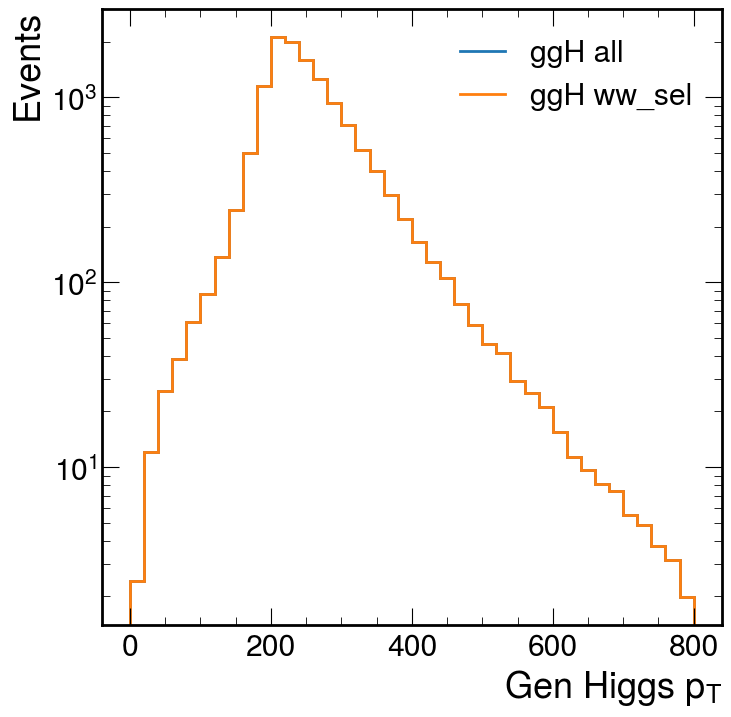

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["ggH"]:
    for tag in ["all", "ww_sel"]:
        mplhep.histplot(
            h_hpt[{"name": key, "tag": tag}],
            #density=True,
            lw=2,
            label=f"ggH {tag}",
            flow="none"
        )
        print(h_hpt[{"name": key, "tag": tag}].sum())
ax.set_yscale("log")
ax.set_ylabel("Events")        
ax.legend()